In [1]:
import sys
from skimage.morphology import square,dilation, erosion
sys.path.append(r'/home/localuser/Datacube/data_cube_notebooks')
from utils.data_cube_utilities.dc_display_map import display_map
from datetime import datetime
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scripts.data import *
from scripts.combiner import *
from scripts.view import *
import time

In [2]:
latitude = (50.38, 51.00)
longitude = ( 30.7 , 29)
time = ['2019-05-31', '2019-07-30']

In [3]:
import datacube
dc = datacube.Datacube(app = 'my_app', config = '/home/localuser/.datacube.conf')

In [4]:
from scripts.data import DataLoader
data = DataLoader(dc = dc,
                  latitude = latitude,
                  longitude = longitude,                         
                  time = time,
                  chunk_size  = (2000,2000)
                  )
data.load_data(True)

Matrix of chunks: 
[[ 0  1  2  3  4  5  6]
 [ 7  8  9 10 11 12 13]
 [14 15 16 17 18 19 20]
 [21 22 23 24 25 26 27]]


#### парами
4- 3.39
5- 6.02
7- 15.65
8 -22.38
9 -30.20
10 -38.70

вікном по 3
4-0.93
5-1.29
7-1.93
8-2.27
9-2.55
10-2.91

In [5]:
chunk = data[11]#11,10
chunk = drop_empty_data(chunk)
chunk = drop_threshold_cloudiness(chunk,save_dims= False)#threshold = 0.4

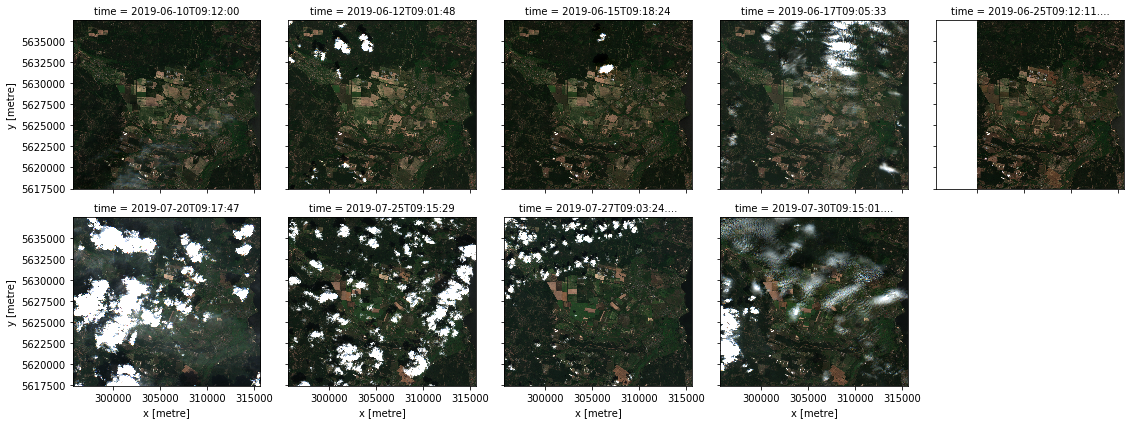

In [25]:
plotting_xarray(chunk)

In [16]:
#r = np.nanmedian(driver(chunk), axis = 0)

In [11]:
#plot_composite(5*r)

In [6]:
#plot_comp_from_mask(chunk, 3, 9)

In [26]:
get_info(chunk)
#plotting_xarray(chunk_with_drop)

,time,cloudiness_percentage,cirrus_percetage,nan_percetage of whole comp
0,2019-06-10T09:12:00.000000000,0.054980,0.035140,0.000
1,2019-06-12T09:01:48.000000000,0.026475,0.000000,0.000
2,2019-06-15T09:18:24.000000000,0.026759,0.000000,0.000
3,2019-06-17T09:05:33.000000000,0.056863,0.000000,0.000
4,2019-06-25T09:12:11.500000000,0.024962,0.000000,0.218
5,2019-07-20T09:17:47.000000000,0.333603,0.004892,0.000
6,2019-07-25T09:15:29.000000000,0.225473,0.000000,0.000
7,2019-07-27T09:03:24.500000000,0.063654,0.000000,0.000
8,2019-07-30T09:15:01.500000000,0.086192,0.004078,0.000


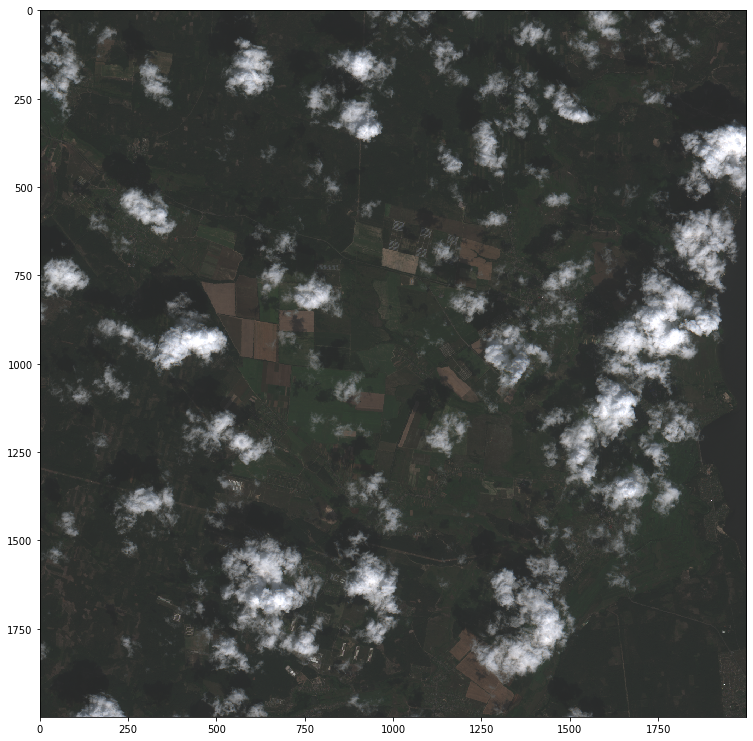

In [27]:
ploting_rgb_xarray_for_one_day(chunk, 6)

In [162]:
chunk.slc.attrs

OrderedDict([('units', '1'),
             ('nodata', 0),
             ('flags_definition',
              {'slc': {'bits': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
                'values': {'1': 'Saturated or defective pixel',
                 '2': 'Dark features / Shadows',
                 '3': 'Cloud shadows',
                 '4': 'Vegetation',
                 '5': 'Not vegetated',
                 '6': 'Water',
                 '7': 'Unclassified',
                 '8': 'Cloud medium probability',
                 '9': 'cloud high probability',
                 '10': 'Thin cirrus',
                 '11': 'Snow or ice'},
                'description': 'Scene classification'}}),
             ('crs', CRS('EPSG:32636'))])

In [199]:
base_mask = get_mask(chunk,6).astype('int16')#[:500,:500]
base_defects = (base_mask == 2) | (base_mask == 3) | (base_mask == 8) | (base_mask == 9)

In [200]:
Y_TRUE = np.copy(base_defects)

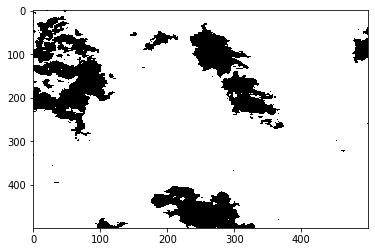

In [202]:
apply_true_false_mask(Y_TRUE[:500,:500])

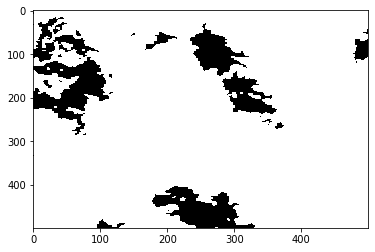

In [204]:
apply_true_false_mask(base_defects[:500,:500])

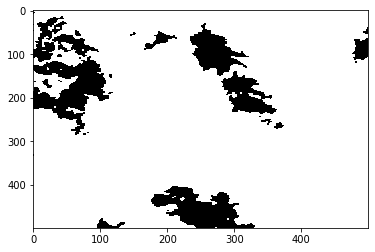

In [205]:
base_defects_dil = dilation(base_defects, square(2))
apply_true_false_mask(base_defects_dil[:500,:500])

In [206]:
# процент хмар в Y_TRUE
np.sum(Y_TRUE)/(Y_TRUE.shape[0]*Y_TRUE.shape[1])

0.22547275

In [207]:
# процент хмар в зменшеній 'оригінальній від COAH'
np.sum(base_defects)/(base_defects.shape[0]*base_defects.shape[1])

0.187328

In [208]:
# процент хмар в збільшеній
np.sum(base_defects_dil)/(base_defects_dil.shape[0]*base_defects_dil.shape[1])

0.2025235

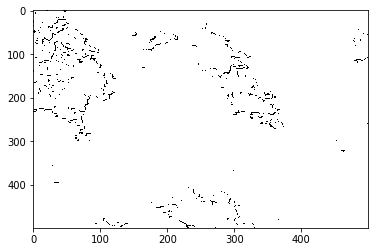

In [209]:
apply_true_false_mask(np.bitwise_xor(Y_TRUE,base_defects_dil)[:500,:500])

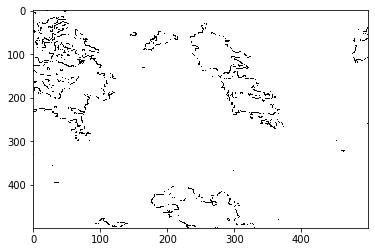

In [210]:
apply_true_false_mask(np.bitwise_xor(Y_TRUE,base_defects)[:500,:500])

In [211]:
from scipy.stats import pearsonr
from scipy.stats import chisquare
from scipy.stats import spearmanr
from scipy.stats import power_divergence
from scipy.stats import kendalltau
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from scipy.spatial import distance

In [212]:
from sklearn.metrics import explained_variance_score, max_error,mean_absolute_error,mean_squared_error
from sklearn.metrics import mean_squared_log_error, median_absolute_error, r2_score

In [213]:
def simularity_metrics(y_true,y_pred):
    print('Pearsons correlation: %.3f' % pearsonr(y_true, y_pred)[0])
    print('Spearmans correlation: %.3f' % spearmanr(y_true, y_pred)[0])
    print('Kendalls tau: %.3f' % kendalltau(y_true, y_pred)[0])
    #print('Cosine similarity: %.3f' % cosine_similarity(y_true.reshape(-1, 1), y_pred.reshape(-1, 1)))
    print('Jaccard similarity: %.3f' % jaccard_score(y_true, y_pred))
    print('Euclidean distance: %.3f' % distance.euclidean(y_true, y_pred))
    print('Manhattan distance: %.3f' % distance.cityblock(y_true, y_pred))

In [214]:
simularity_metrics(Y_TRUE.astype(int).ravel(),base_defects_dil.astype(int).ravel())

Pearsons correlation: 0.934
Spearmans correlation: 0.934
Kendalls tau: 0.934
Jaccard similarity: 0.898
Euclidean distance: 302.980
Manhattan distance: 91797.000


In [215]:
simularity_metrics(Y_TRUE.astype(int).ravel(),base_defects.astype(int).ravel())

Pearsons correlation: 0.890
Spearmans correlation: 0.890
Kendalls tau: 0.890
Jaccard similarity: 0.831
Euclidean distance: 390.614
Manhattan distance: 152579.000


In [86]:
base_defects_dil.astype(bool)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

OrderedDict([('units', '1'), ('nodata', 0), ('flags_definition', {'slc': {'bits': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'values': {'1': 'Saturated or defective pixel', '2': 'Dark features / Shadows', '3': 'Cloud shadows', '4': 'Vegetation', '5': 'Not vegetated', '6': 'Water', '7': 'Unclassified', '8': 'Cloud medium probability', '9': 'cloud high probability', '10': 'Thin cirrus', '11': 'Snow or ice'}, 'description': 'Scene classification'}}), ('crs', CRS('EPSG:32636'))])


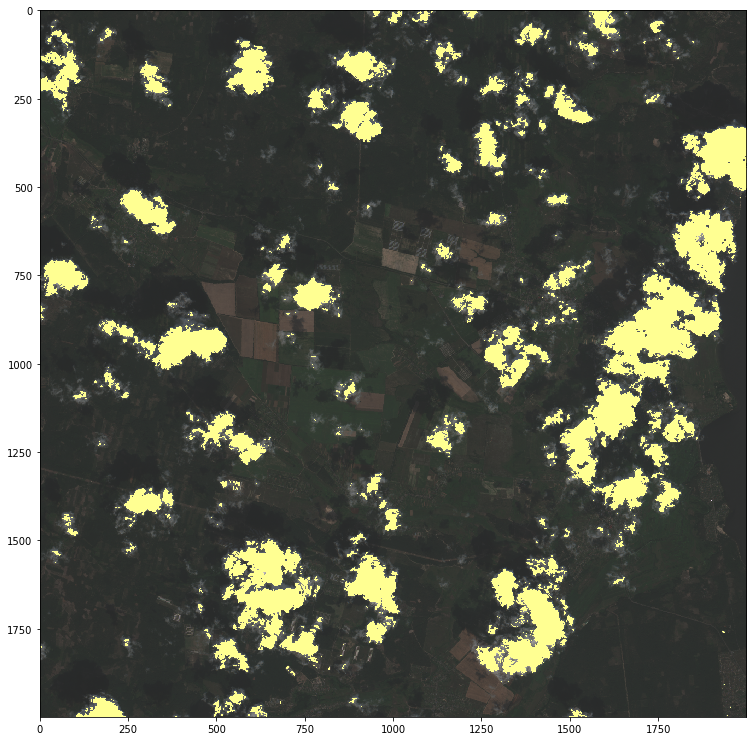

In [39]:
plot_comp_from_mask(chunk,day_idx= 6,mask_class =9)